**Considered Problem :** In this notebook, we use different feature containing demographical data, social-economic factors and academic performance in order to predict student dropout. The dataset contains informations on students in Portugal between 2008/2009 and 2018/2019.

**Research question :** The main goal is to see how we can deal with such a difficult problem. Indeed, we do not have that much information with the features (especially regarding the past results) and the number of examples is small (4424 rows). We will compare different methods to address this problem. Then, we will look at the impact of the different features. Finally, we will see how adding information about the first and second semesters influence the model performance.

The notebook is structured as follows :

<a id='top'></a>
[1. Data Import & Inspection](#data) <br>
[2. Comparison between several methods](#compar) <br>
&emsp; [2.1 LightGBM](#lgbm) <br>
&emsp; [2.2 Support Vector Machines](#svm) <br>
&emsp; [2.3 SGD Classifier](#sgd) <br>
&emsp; [2.4 K-Nearest Neighbours](#knn) <br>
&emsp; [2.5 Random Forest](#rf) <br>
&emsp; [2.6 Feedforward Neural Networks](#fnn) <br>
[3. Improvement of the best method](#imp) <br>
[4. Feature Importance](#explain) <br>
[5. Impact of using part or all of the features](#impact) <br>
&emsp; [5.1 Impact of the social-economic factors](#demo) <br>
&emsp; [5.2 Impact of adding curriculum-related features](#cv) <br>
&emsp; &emsp; [5.2.1 Using only the first semester](#first) <br>
&emsp; &emsp; [5.2.2 Using both semesters](#both) <br>
[6. Conclusion](#conclusion) <br>

In [328]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt

import keras
from keras.layers import Conv2D, MaxPool2D,Dropout,Flatten,Dense
from keras.preprocessing import image 
from keras.models import Sequential

In [18]:
pd.set_option('display.max_columns', None)

# 1. Data import and inspection<a id='data'></a>
[to the top](#top)

The dataset I will use is available here : https://www.kaggle.com/datasets/thedevastator/higher-education-predictors-of-student-retention?datasetId=2780494&sortBy=voteCount 

You can fin more information about it in this paper : https://www.mdpi.com/2306-5729/7/11/146

In [410]:
df = pd.read_csv('dataset.csv')

In [411]:
df

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,Father's occupation,Displaced,Educational special needs,Debtor,Tuition fees up to date,Gender,Scholarship holder,Age at enrollment,International,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,8,5,2,1,1,1,13,10,6,10,1,0,0,1,1,0,20,0,0,0,0,0,0.000000,0,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,6,1,11,1,1,1,1,3,4,4,1,0,0,0,1,0,19,0,0,6,6,6,14.000000,0,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,5,1,1,1,22,27,10,10,1,0,0,0,1,0,19,0,0,6,0,0,0.000000,0,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,8,2,15,1,1,1,23,27,6,4,1,0,0,1,0,0,20,0,0,6,8,6,13.428571,0,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,12,1,3,0,1,1,22,28,10,10,0,0,0,1,0,0,45,0,0,6,9,5,12.333333,0,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,1,1,6,15,1,1,1,1,1,6,5,0,0,0,1,1,0,19,0,0,6,7,5,13.600000,0,0,6,8,5,12.666667,0,15.5,2.8,-4.06,Graduate
4420,1,1,2,15,1,1,19,1,1,10,10,1,0,1,0,0,0,18,1,0,6,6,6,12.000000,0,0,6,6,2,11.000000,0,11.1,0.6,2.02,Dropout
4421,1,1,1,12,1,1,1,22,27,10,10,1,0,0,1,0,1,30,0,0,7,8,7,14.912500,0,0,8,9,1,13.500000,0,13.9,-0.3,0.79,Dropout
4422,1,1,1,9,1,1,1,22,27,8,5,1,0,0,1,0,1,20,0,0,5,5,5,13.800000,0,0,5,6,5,12.000000,0,9.4,-0.8,-3.12,Graduate


In [412]:
df['Target'].value_counts()

Graduate    2209
Dropout     1421
Enrolled     794
Name: Target, dtype: int64

We can see that the dataset is imbalanced regarding the target. Almost half of the students graduated, the rest dropped out or were enrolled.

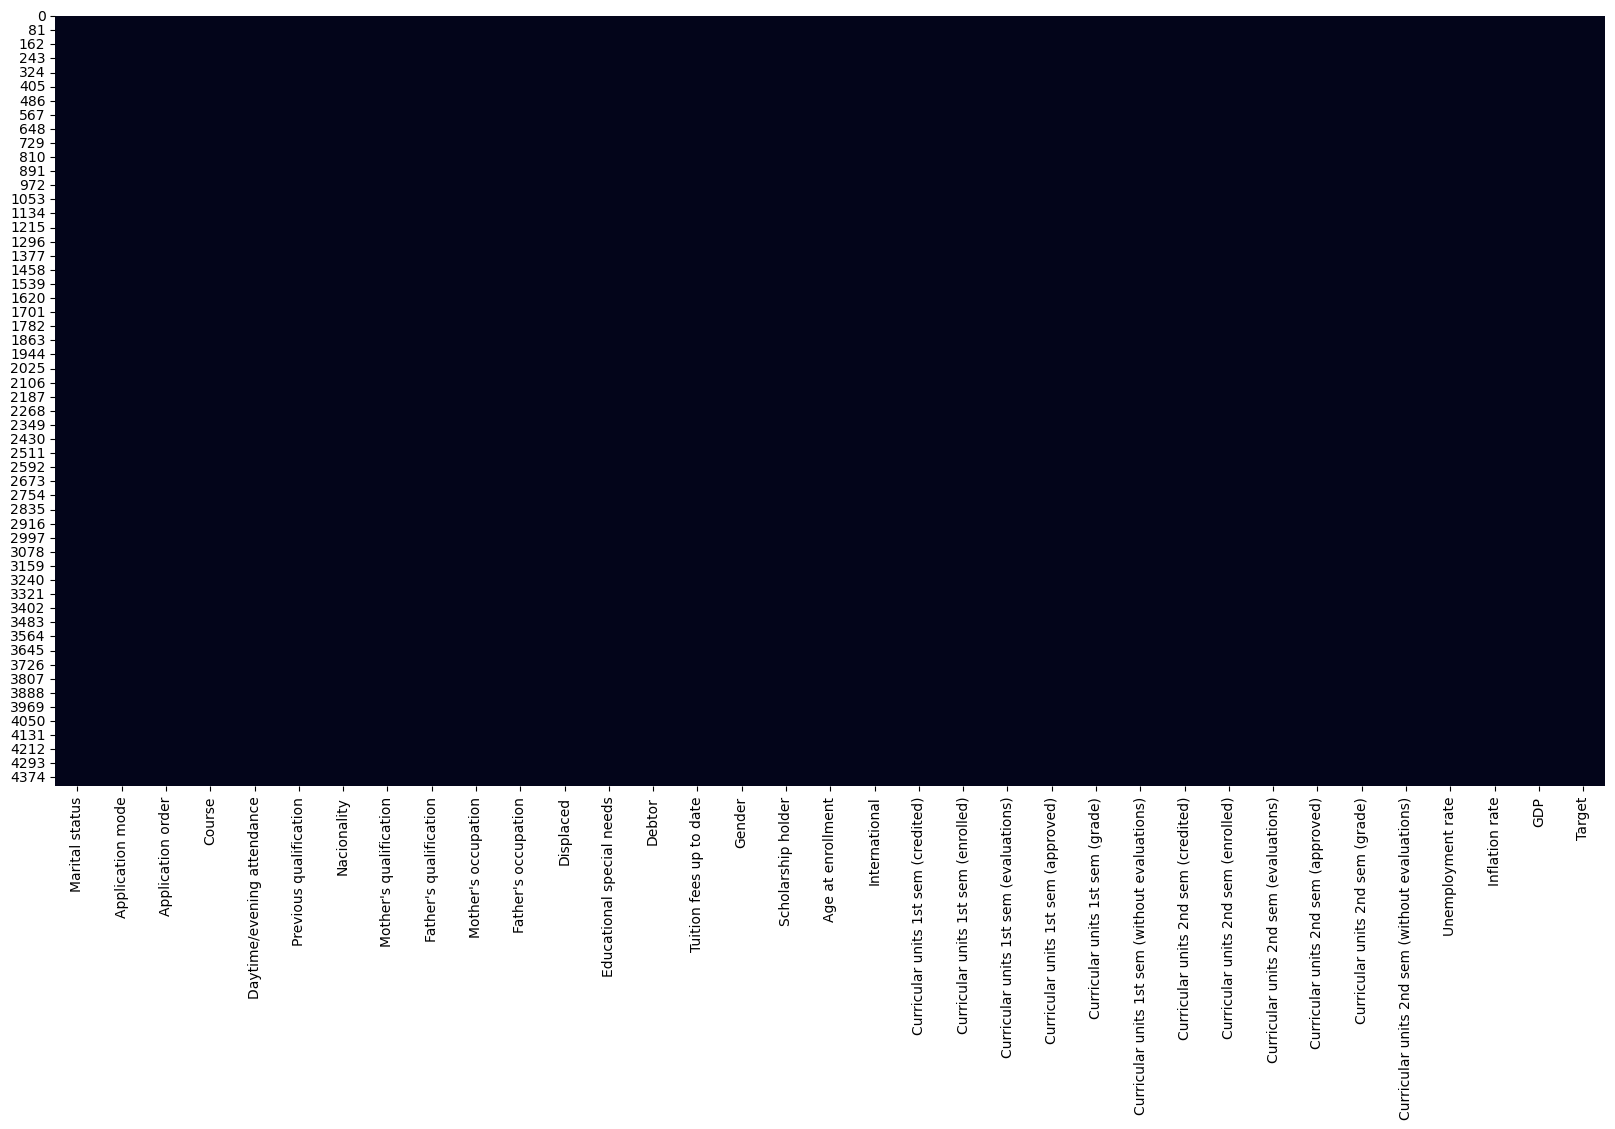

In [413]:
plt.figure(figsize=(20,10))
sns.heatmap(df.isna(), cbar=False)
plt.show()

Fortunately, the dataset is very clean. Indeed, there is not any NaN value.

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_7600\2595855147.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


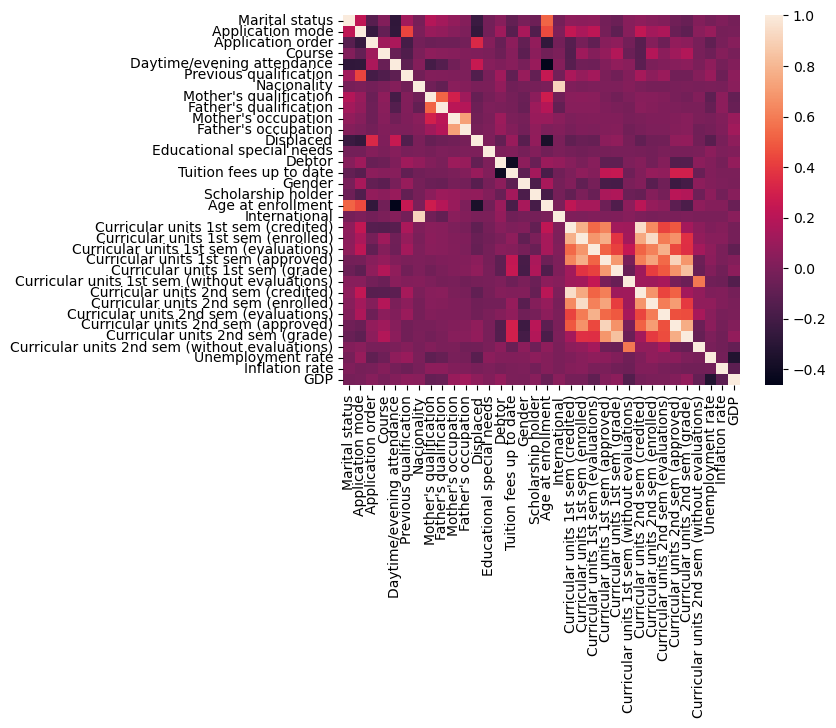

In [414]:
corr = df.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=False, annot_kws={'fontsize': 15})
plt.show()

In this matrix, there are three area of strong correlation. First, there is logic link between 'Nationality' and 'International' because international students are not Portuguese by definition. Then, we can see correlations between the mother and the father regarding their qualification and their occupation. Finally, all academic features, especially regarding the success, are correlated with each other. 

But, the most important correlations are those with the target. We will look at that now.

## Correlations with the target

In [415]:
df.replace("Dropout",0,inplace=True)
df.replace("Enrolled",1,inplace=True)
df.replace("Graduate",2,inplace=True)

The encoding is made in such a way that a positive correlation with the target reflect a positivive correlation with the chance of graduating.

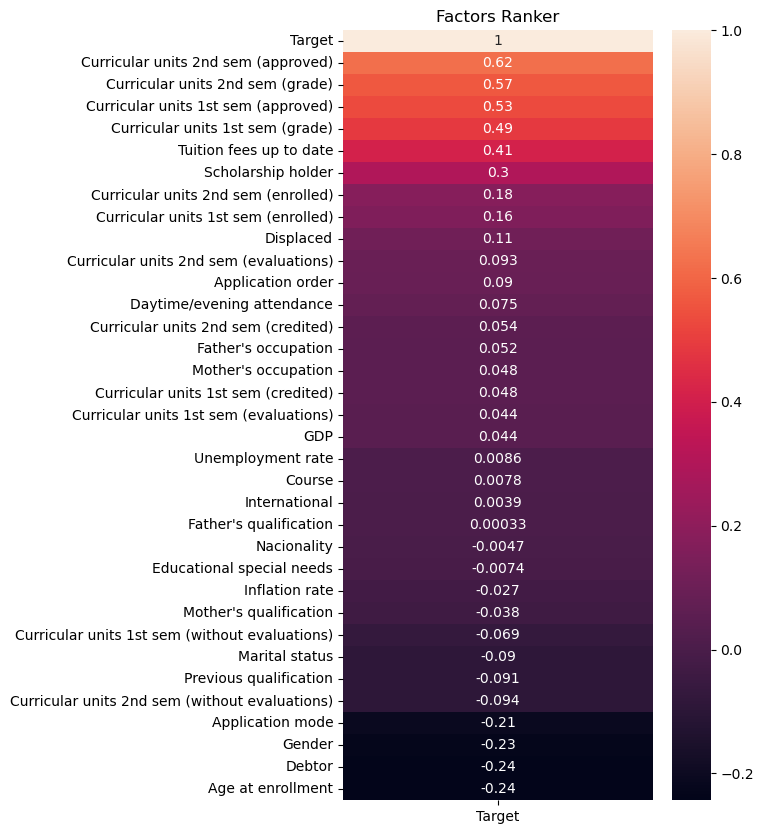

In [416]:
plt.figure(figsize = (5,10))
sns.heatmap(df.corr()[['Target']].sort_values(by='Target', ascending=False), annot = True)
plt.title('Factors Ranker')
plt.show()

Quite logically, the most positively correlated factors are the academic features, especially the grades and the number of approved units. Then, the following variables are 'Tuition fess up to date' and 'Scholarship holder'.
So, paying your fees in time and being a scholarship holder are good signs. 'Application Mode', 'Gender', 'Debtor' and 'Age at enrollment' are the most negatively correlated factors. Then, you have less chance of graduating depending on your gender, your application mode, if you are a debtor and if you are older than usual.

# 2. Comparison between several methods<a id='compar'></a>
[to the top](#top)

## 2.1 LightGBM<a id='lgbm'></a>

For the first implementations, I will not use the academic features because that is not not something we can observe before the beginning of the year, when it is the most important to detect the potential dropouts.

As a gradient boosting library, I chose LightGBM. It is currently the best of all even if its main advantage (its speed) will not be very useful here.

In [484]:
df_features = df[['Marital status', 'Application mode', 'Application order', 'Course',
       'Daytime/evening attendance', 'Previous qualification', 'Nacionality',
       "Mother's qualification", "Father's qualification",
       "Mother's occupation", "Father's occupation", 'Displaced',
       'Educational special needs', 'Debtor', 'Tuition fees up to date',
       'Gender', 'Scholarship holder', 'Age at enrollment', 'International', 'Unemployment rate',
       'Inflation rate', 'GDP', 'Target']]

In [485]:
X_features = df_features.drop(['Target'], axis=1)
y_features = df_features['Target']

In [486]:
X_train, X_test, y_train, y_test = train_test_split(X_features, y_features, test_size = 0.15, random_state = 0)

In [487]:
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)

LGBMClassifier()

In [488]:
y_pred=clf.predict(X_test)

In [489]:
accuracy=accuracy_score(y_pred, y_test)
print(f'The model overall accuracy is : {round(accuracy,2)}')

The model overall accuracy is : 0.67


In [490]:
accuracy=accuracy_score(y_pred[y_test == 0], y_test[y_test == 0])
print(f'The model accuracy when the target is "Dropout" is : {round(accuracy,2)} ({len(y_pred[y_test == 0])} values tested)')

The model accuracy when the target is "Dropout" is : 0.65 (216 values tested)


In [491]:
accuracy=accuracy_score(y_pred[y_test == 1], y_test[y_test == 1])
print(f'The model accuracy when the target is "Enrolled" is : {round(accuracy,2)} ({len(y_pred[y_test == 1])} values tested)')

The model accuracy when the target is "Enrolled" is : 0.21 (120 values tested)


In [492]:
accuracy=accuracy_score(y_pred[y_test == 2], y_test[y_test == 2])
print(f'The model accuracy when the target is "Graduate" is : {round(accuracy,2)} ({len(y_pred[y_test == 2])} values tested)')

The model accuracy when the target is "Graduate" is : 0.84 (328 values tested)


The overall accuracy for this default version of LightGBM is good. However, the accuracy is very different across the different classes, probably due to the imbalance data.

Moreover, the minority class is very particular. It is an in-between between graduating and dropping out, difficult to predict. I did not find precise information about that but I think 'Enrolled' means that the student got enrolled in an other domain of study at the end of the year. I plotted the distribution of grades at the second semester for those students as well as the distribution of approved units and comapred it with the graduated students but I cannot be sure of my idea.

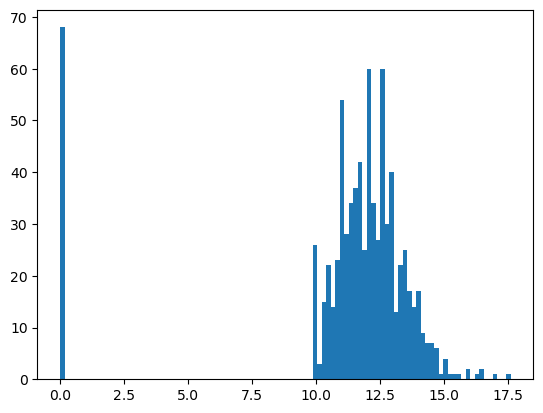

In [438]:
plt.hist(df[df['Target'] == 1]['Curricular units 2nd sem (grade)'], bins=100)
plt.show()

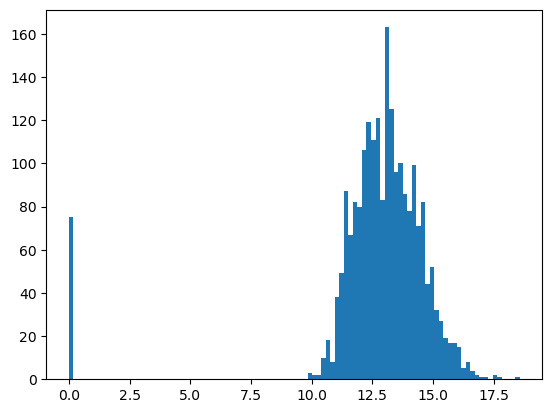

In [439]:
plt.hist(df[df['Target'] == 2]['Curricular units 2nd sem (grade)'], bins=100)
plt.show()

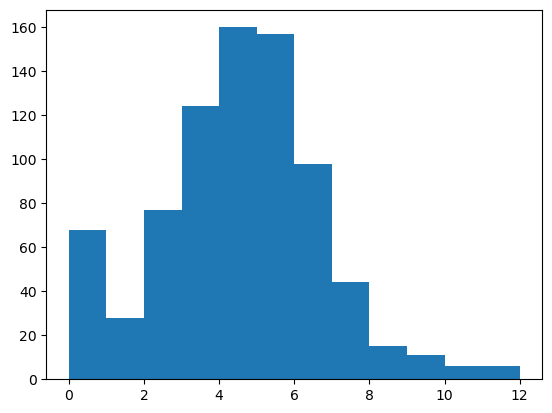

In [447]:
plt.hist(df[df['Target'] == 1]['Curricular units 2nd sem (approved)'], bins=12)
plt.show()

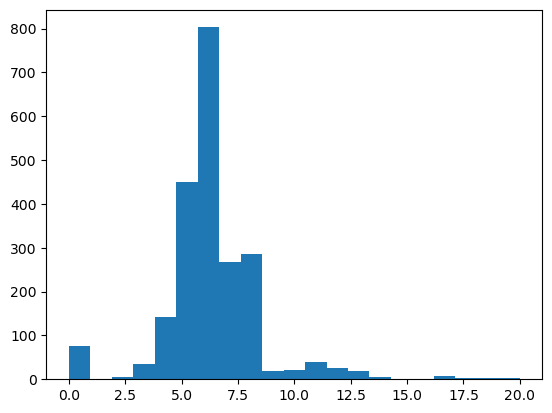

In [449]:
plt.hist(df[df['Target'] == 2]['Curricular units 2nd sem (approved)'], bins=21)
plt.show()

## 2.2 Support Vector Machines<a id='svm'></a>

In [493]:
df_features = df[['Marital status', 'Application mode', 'Application order', 'Course',
       'Daytime/evening attendance', 'Previous qualification', 'Nacionality',
       "Mother's qualification", "Father's qualification",
       "Mother's occupation", "Father's occupation", 'Displaced',
       'Educational special needs', 'Debtor', 'Tuition fees up to date',
       'Gender', 'Scholarship holder', 'Age at enrollment', 'International', 'Unemployment rate',
       'Inflation rate', 'GDP', 'Target']]

In [494]:
X_features = df_features.drop(['Target'], axis=1)
y_features = df_features['Target']

In [495]:
X_train, X_test, y_train, y_test = train_test_split(X_features, y_features, test_size = 0.15, random_state = 0)

In [498]:
clf = SVC(kernel='linear', C=1, decision_function_shape='ovo')

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

In [499]:
accuracy=accuracy_score(y_pred, y_test)
print(f'The model overall accuracy is : {round(accuracy,2)}')

The model overall accuracy is : 0.59


In [500]:
accuracy=accuracy_score(y_pred[y_test == 0], y_test[y_test == 0])
print(f'The model accuracy when the target is "Dropout" is : {round(accuracy,2)} ({len(y_pred[y_test == 0])} values tested)')

The model accuracy when the target is "Dropout" is : 0.43 (216 values tested)


In [501]:
accuracy=accuracy_score(y_pred[y_test == 1], y_test[y_test == 1])
print(f'The model accuracy when the target is "Enrolled" is : {round(accuracy,2)} ({len(y_pred[y_test == 1])} values tested)')

The model accuracy when the target is "Enrolled" is : 0.0 (120 values tested)


In [502]:
accuracy=accuracy_score(y_pred[y_test == 2], y_test[y_test == 2])
print(f'The model accuracy when the target is "Graduate" is : {round(accuracy,2)} ({len(y_pred[y_test == 2])} values tested)')

The model accuracy when the target is "Graduate" is : 0.91 (328 values tested)


The overall accuracy of SVM is worst than that of LightGBM and the imbalance has even more impact here. 

## 2.3 SGD Classifier<a id='sgd'></a>

In [503]:
df_features = df[['Marital status', 'Application mode', 'Application order', 'Course',
       'Daytime/evening attendance', 'Previous qualification', 'Nacionality',
       "Mother's qualification", "Father's qualification",
       "Mother's occupation", "Father's occupation", 'Displaced',
       'Educational special needs', 'Debtor', 'Tuition fees up to date',
       'Gender', 'Scholarship holder', 'Age at enrollment', 'International', 'Unemployment rate',
       'Inflation rate', 'GDP', 'Target']]

In [504]:
X_features = df_features.drop(['Target'], axis=1)
y_features = df_features['Target']

In [505]:
X_train, X_test, y_train, y_test = train_test_split(X_features, y_features, test_size = 0.15, random_state = 0)

In [506]:
clf = SGDClassifier(max_iter=1000, tol=1e-3)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

In [509]:
accuracy=accuracy_score(y_pred, y_test)
print(f'The model overall accuracy is : {round(accuracy,2)}')

The model overall accuracy is : 0.58


In [510]:
accuracy=accuracy_score(y_pred[y_test == 0], y_test[y_test == 0])
print(f'The model accuracy when the target is "Dropout" is : {round(accuracy,2)} ({len(y_pred[y_test == 0])} values tested)')

The model accuracy when the target is "Dropout" is : 0.56 (216 values tested)


In [511]:
accuracy=accuracy_score(y_pred[y_test == 1], y_test[y_test == 1])
print(f'The model accuracy when the target is "Enrolled" is : {round(accuracy,2)} ({len(y_pred[y_test == 1])} values tested)')

The model accuracy when the target is "Enrolled" is : 0.08 (120 values tested)


In [512]:
accuracy=accuracy_score(y_pred[y_test == 2], y_test[y_test == 2])
print(f'The model accuracy when the target is "Graduate" is : {round(accuracy,2)} ({len(y_pred[y_test == 2])} values tested)')

The model accuracy when the target is "Graduate" is : 0.78 (328 values tested)


The SGD Classifier is similar to the SVM so it shows bad results as well.

## 2.4 K-Nearest Neighbours<a id='knn'></a>

In [450]:
df_features = df[['Marital status', 'Application mode', 'Application order', 'Course',
       'Daytime/evening attendance', 'Previous qualification', 'Nacionality',
       "Mother's qualification", "Father's qualification",
       "Mother's occupation", "Father's occupation", 'Displaced',
       'Educational special needs', 'Debtor', 'Tuition fees up to date',
       'Gender', 'Scholarship holder', 'Age at enrollment', 'International', 'Unemployment rate',
       'Inflation rate', 'GDP', 'Target']]

In [451]:
X_features = df_features.drop(['Target'], axis=1)
y_features = df_features['Target']

In [452]:
X_train, X_test, y_train, y_test = train_test_split(X_features, y_features, test_size = 0.15, random_state = 0)

I tested different number of neighbours and I got the best results with 45, which is very high. In fact, that is not totally surprising because the task is difficult to resolve with these features. Due to that, the nearest neighbours will often have different values so it is usually interesting to look at more points. The main drawback is that minority classes are badly predicted.

In [516]:
knn = KNeighborsClassifier(n_neighbors=45)

knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

In [517]:
accuracy=accuracy_score(y_pred, y_test)
print(f'The model overall accuracy is : {round(accuracy,2)}')

The model overall accuracy is : 0.57


In [518]:
accuracy=accuracy_score(y_pred[y_test == 0], y_test[y_test == 0])
print(f'The model accuracy when the target is "Dropout" is : {round(accuracy,2)} ({len(y_pred[y_test == 0])} values tested)')

The model accuracy when the target is "Dropout" is : 0.4 (216 values tested)


In [519]:
accuracy=accuracy_score(y_pred[y_test == 1], y_test[y_test == 1])
print(f'The model accuracy when the target is "Enrolled" is : {round(accuracy,2)} ({len(y_pred[y_test == 1])} values tested)')

The model accuracy when the target is "Enrolled" is : 0.02 (120 values tested)


In [520]:
accuracy=accuracy_score(y_pred[y_test == 2], y_test[y_test == 2])
print(f'The model accuracy when the target is "Graduate" is : {round(accuracy,2)} ({len(y_pred[y_test == 2])} values tested)')

The model accuracy when the target is "Graduate" is : 0.88 (328 values tested)


As expected, the KNN algorithm was very bad for minority classes, which results in an overall bad performance.

## 2.5 Random Forest<a id='rf'></a>

In [523]:
df_features = df[['Marital status', 'Application mode', 'Application order', 'Course',
       'Daytime/evening attendance', 'Previous qualification', 'Nacionality',
       "Mother's qualification", "Father's qualification",
       "Mother's occupation", "Father's occupation", 'Displaced',
       'Educational special needs', 'Debtor', 'Tuition fees up to date',
       'Gender', 'Scholarship holder', 'Age at enrollment', 'International', 'Unemployment rate',
       'Inflation rate', 'GDP', 'Target']]

In [524]:
X_features = df_features.drop(['Target'], axis=1)
y_features = df_features['Target']

In [525]:
X_train, X_test, y_train, y_test = train_test_split(X_features, y_features, test_size = 0.15, random_state = 0)

In [526]:
clf = RandomForestClassifier(max_depth=2, random_state=0)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

In [531]:
accuracy=accuracy_score(y_pred, y_test)
print(f'The model overall accuracy is : {round(accuracy,2)}')

The model overall accuracy is : 0.6


In [532]:
accuracy=accuracy_score(y_pred[y_test == 0], y_test[y_test == 0])
print(f'The model accuracy when the target is "Dropout" is : {round(accuracy,2)} ({len(y_pred[y_test == 0])} values tested)')

The model accuracy when the target is "Dropout" is : 0.35 (216 values tested)


In [533]:
accuracy=accuracy_score(y_pred[y_test == 1], y_test[y_test == 1])
print(f'The model accuracy when the target is "Enrolled" is : {round(accuracy,2)} ({len(y_pred[y_test == 1])} values tested)')

The model accuracy when the target is "Enrolled" is : 0.0 (120 values tested)


In [534]:
accuracy=accuracy_score(y_pred[y_test == 2], y_test[y_test == 2])
print(f'The model accuracy when the target is "Graduate" is : {round(accuracy,2)} ({len(y_pred[y_test == 2])} values tested)')

The model accuracy when the target is "Graduate" is : 0.98 (328 values tested)


The random forest method performs less well than LightGBM. That is logic because the gradient boosting method allows to add the benefits of the ensemble methods (especially boosting) to the random forest.

## 2.6 Feedforward Neural Networks<a id='fnn'></a>

In [535]:
df_features = df[['Marital status', 'Application mode', 'Application order', 'Course',
       'Daytime/evening attendance', 'Previous qualification', 'Nacionality',
       "Mother's qualification", "Father's qualification",
       "Mother's occupation", "Father's occupation", 'Displaced',
       'Educational special needs', 'Debtor', 'Tuition fees up to date',
       'Gender', 'Scholarship holder', 'Age at enrollment', 'International', 'Unemployment rate',
       'Inflation rate', 'GDP', 'Target']]

In [536]:
df_fnn = df_features.copy()

To apply a FNN to our dataset we first need to one-hot encode all categorical features.

In [537]:
df_fnn[['Marital status', 'Application mode', 'Course',
       'Daytime/evening attendance', 'Previous qualification', 'Nacionality',
       "Mother's qualification", "Father's qualification",
       "Mother's occupation", "Father's occupation", 'Displaced',
       'Educational special needs', 'Debtor', 'Tuition fees up to date',
       'Gender', 'Scholarship holder', 'International']] = df_fnn[['Marital status', 'Application mode', 'Course',
       'Daytime/evening attendance', 'Previous qualification', 'Nacionality',
       "Mother's qualification", "Father's qualification",
       "Mother's occupation", "Father's occupation", 'Displaced',
       'Educational special needs', 'Debtor', 'Tuition fees up to date',
       'Gender', 'Scholarship holder', 'International']].astype('category')

In [538]:
X_fnn = df_fnn.drop(['Target'], axis=1)
y_fnn = df_fnn['Target']

In [539]:
X_fnn = pd.get_dummies(X_fnn)
y_fnn = pd.get_dummies(y_fnn)

In [540]:
X_train, X_test, y_train, y_test = train_test_split(X_fnn, y_fnn, test_size = 0.15, random_state = 0)

I start with a very simple network, containing only one hidden layer. The dataset is small so we want to prevent overfitting. The main idea for that is to simplify the architecture.

In [541]:
model=keras.Sequential([
    keras.layers.Dense(units=128, activation="relu"),
    keras.layers.Dense(3, activation='softmax'),
])

model.compile(optimizer="adam",loss='categorical_crossentropy',metrics=['accuracy'])

In [542]:
model.fit(x=X_train, y=y_train, epochs=3, batch_size=3, validation_split=0.15)

Epoch 1/3
1066/1066 [==============================] - 3s 2ms/step - loss: 0.9301 - accuracy: 0.5961 - val_loss: 0.8494 - val_accuracy: 0.6436
Epoch 2/3
1066/1066 [==============================] - 2s 2ms/step - loss: 0.8216 - accuracy: 0.6436 - val_loss: 0.8484 - val_accuracy: 0.6418
Epoch 3/3
1066/1066 [==============================] - 2s 2ms/step - loss: 0.8037 - accuracy: 0.6492 - val_loss: 0.8324 - val_accuracy: 0.6348


In [543]:
loss_accuracy, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy : {np.round(test_accuracy,3)}")

21/21 [==============================] - 0s 3ms/step - loss: 0.8389 - accuracy: 0.6340
Test accuracy : 0.634


After 3 epochs, the accuracy is not impressive but we can hope improve it with more epochs.

In [544]:
model.fit(x=X_train, y=y_train, epochs=10, batch_size=3, validation_split=0.15)

Epoch 1/10
1066/1066 [==============================] - 2s 2ms/step - loss: 0.7857 - accuracy: 0.6580 - val_loss: 0.8331 - val_accuracy: 0.6259
Epoch 2/10
1066/1066 [==============================] - 2s 2ms/step - loss: 0.7732 - accuracy: 0.6611 - val_loss: 0.8742 - val_accuracy: 0.6259
Epoch 3/10
1066/1066 [==============================] - 2s 2ms/step - loss: 0.7594 - accuracy: 0.6737 - val_loss: 0.8609 - val_accuracy: 0.6330
Epoch 4/10
1066/1066 [==============================] - 2s 2ms/step - loss: 0.7475 - accuracy: 0.6696 - val_loss: 0.8497 - val_accuracy: 0.6383
Epoch 5/10
1066/1066 [==============================] - 2s 2ms/step - loss: 0.7296 - accuracy: 0.6909 - val_loss: 0.9190 - val_accuracy: 0.6117
Epoch 6/10
1066/1066 [==============================] - 2s 2ms/step - loss: 0.7220 - accuracy: 0.6865 - val_loss: 0.8301 - val_accuracy: 0.6472
Epoch 7/10
1066/1066 [==============================] - 2s 2ms/step - loss: 0.7021 - accuracy: 0.7028 - val_loss: 0.8510 - val_accuracy:

In [546]:
loss_accuracy, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy : {np.round(test_accuracy,3)}")

21/21 [==============================] - 0s 2ms/step - loss: 0.8653 - accuracy: 0.6370
Test accuracy : 0.637


With 10 more epochs, the accuracy did not improve a lot. Since the training is fast, we can see what happens with 100 more pochs.

In [547]:
model.fit(x=X_train, y=y_train, epochs=100, batch_size=3, validation_split=0.15)

Epoch 1/100
1066/1066 [==============================] - 2s 2ms/step - loss: 0.6366 - accuracy: 0.7287 - val_loss: 0.8844 - val_accuracy: 0.6348
Epoch 2/100
1066/1066 [==============================] - 2s 2ms/step - loss: 0.6133 - accuracy: 0.7416 - val_loss: 0.9136 - val_accuracy: 0.6046
Epoch 3/100
1066/1066 [==============================] - 2s 2ms/step - loss: 0.6005 - accuracy: 0.7600 - val_loss: 0.9182 - val_accuracy: 0.6259
Epoch 4/100
1066/1066 [==============================] - 2s 2ms/step - loss: 0.5865 - accuracy: 0.7534 - val_loss: 0.9005 - val_accuracy: 0.6312
Epoch 5/100
1066/1066 [==============================] - 2s 2ms/step - loss: 0.5674 - accuracy: 0.7710 - val_loss: 0.9319 - val_accuracy: 0.6365
Epoch 6/100
1066/1066 [==============================] - 2s 2ms/step - loss: 0.5522 - accuracy: 0.7703 - val_loss: 0.9602 - val_accuracy: 0.6330
Epoch 7/100
1066/1066 [==============================] - 2s 2ms/step - loss: 0.5311 - accuracy: 0.7866 - val_loss: 0.9383 - val_ac

1066/1066 [==============================] - 2s 2ms/step - loss: 0.0990 - accuracy: 0.9656 - val_loss: 2.6980 - val_accuracy: 0.5603
Epoch 58/100
1066/1066 [==============================] - 2s 2ms/step - loss: 0.0864 - accuracy: 0.9740 - val_loss: 2.6109 - val_accuracy: 0.5798
Epoch 59/100
1066/1066 [==============================] - 2s 2ms/step - loss: 0.0856 - accuracy: 0.9734 - val_loss: 2.7851 - val_accuracy: 0.5922
Epoch 60/100
1066/1066 [==============================] - 2s 2ms/step - loss: 0.0779 - accuracy: 0.9747 - val_loss: 2.8948 - val_accuracy: 0.5851
Epoch 61/100
1066/1066 [==============================] - 2s 2ms/step - loss: 0.0850 - accuracy: 0.9718 - val_loss: 2.7855 - val_accuracy: 0.5514
Epoch 62/100
1066/1066 [==============================] - 2s 2ms/step - loss: 0.0836 - accuracy: 0.9728 - val_loss: 2.8318 - val_accuracy: 0.5727
Epoch 63/100
1066/1066 [==============================] - 2s 2ms/step - loss: 0.0725 - accuracy: 0.9787 - val_loss: 2.8326 - val_accuracy

In [548]:
loss_accuracy, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy : {np.round(test_accuracy,3)}")

21/21 [==============================] - 0s 2ms/step - loss: 4.0656 - accuracy: 0.5783
Test accuracy : 0.578


The accuracy dropped a lot due to the overfitting. In fact, the val_accuracy did not really increase since the first epoch. It is now time to try an other architecture, slightly more complex.

In [549]:
model=keras.Sequential([
    keras.layers.Dense(units=128, activation="relu"),
    keras.layers.Dense(units=128, activation="relu"),
    keras.layers.Dense(3, activation='softmax'),
])

model.compile(optimizer="adam",loss='categorical_crossentropy',metrics=['accuracy'])

In [550]:
model.fit(x=X_train, y=y_train, epochs=3, batch_size=3, validation_split=0.15)

Epoch 1/3
1066/1066 [==============================] - 3s 2ms/step - loss: 0.9247 - accuracy: 0.5948 - val_loss: 0.8893 - val_accuracy: 0.6046
Epoch 2/3
1066/1066 [==============================] - 2s 2ms/step - loss: 0.8206 - accuracy: 0.6477 - val_loss: 0.8330 - val_accuracy: 0.6188
Epoch 3/3
1066/1066 [==============================] - 2s 2ms/step - loss: 0.7983 - accuracy: 0.6486 - val_loss: 0.8170 - val_accuracy: 0.6312


In [551]:
loss_accuracy, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy : {np.round(test_accuracy,3)}")

21/21 [==============================] - 0s 3ms/step - loss: 0.8248 - accuracy: 0.6431
Test accuracy : 0.643


The accuracy is slightly better than with the previous architecture and val_accuracy still seems to increase after the first epoch.

In [552]:
model.fit(x=X_train, y=y_train, epochs=10, batch_size=3, validation_split=0.15)

Epoch 1/10
1066/1066 [==============================] - 2s 2ms/step - loss: 0.7812 - accuracy: 0.6696 - val_loss: 0.8172 - val_accuracy: 0.6365
Epoch 2/10
1066/1066 [==============================] - 2s 2ms/step - loss: 0.7622 - accuracy: 0.6696 - val_loss: 0.8235 - val_accuracy: 0.6259
Epoch 3/10
1066/1066 [==============================] - 2s 2ms/step - loss: 0.7459 - accuracy: 0.6774 - val_loss: 0.8635 - val_accuracy: 0.6223
Epoch 4/10
1066/1066 [==============================] - 2s 2ms/step - loss: 0.7288 - accuracy: 0.6874 - val_loss: 0.8422 - val_accuracy: 0.6206
Epoch 5/10
1066/1066 [==============================] - 2s 2ms/step - loss: 0.7071 - accuracy: 0.6927 - val_loss: 0.8775 - val_accuracy: 0.6365
Epoch 6/10
1066/1066 [==============================] - 2s 2ms/step - loss: 0.6953 - accuracy: 0.6987 - val_loss: 0.8553 - val_accuracy: 0.6348
Epoch 7/10
1066/1066 [==============================] - 2s 2ms/step - loss: 0.6625 - accuracy: 0.7074 - val_loss: 0.8899 - val_accuracy:

In [553]:
loss_accuracy, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy : {np.round(test_accuracy,3)}")

21/21 [==============================] - 0s 3ms/step - loss: 0.9341 - accuracy: 0.6566
Test accuracy : 0.657


After 10 epochs, the performance is still improving. I add 10 more epochs.

In [554]:
model.fit(x=X_train, y=y_train, epochs=10, batch_size=3, validation_split=0.15)

Epoch 1/10
1066/1066 [==============================] - 2s 2ms/step - loss: 0.5843 - accuracy: 0.7550 - val_loss: 0.9696 - val_accuracy: 0.5940
Epoch 2/10
1066/1066 [==============================] - 2s 2ms/step - loss: 0.5512 - accuracy: 0.7669 - val_loss: 1.0241 - val_accuracy: 0.6152
Epoch 3/10
1066/1066 [==============================] - 2s 2ms/step - loss: 0.5395 - accuracy: 0.7688 - val_loss: 1.0505 - val_accuracy: 0.6170
Epoch 4/10
1066/1066 [==============================] - 2s 2ms/step - loss: 0.5017 - accuracy: 0.7929 - val_loss: 0.9921 - val_accuracy: 0.5798
Epoch 5/10
1066/1066 [==============================] - 2s 2ms/step - loss: 0.4848 - accuracy: 0.7985 - val_loss: 1.0340 - val_accuracy: 0.6064
Epoch 6/10
1066/1066 [==============================] - 2s 2ms/step - loss: 0.4556 - accuracy: 0.8145 - val_loss: 1.0874 - val_accuracy: 0.6152
Epoch 7/10
1066/1066 [==============================] - 2s 2ms/step - loss: 0.4378 - accuracy: 0.8138 - val_loss: 1.1643 - val_accuracy:

In [555]:
loss_accuracy, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy : {np.round(test_accuracy,3)}")

21/21 [==============================] - 0s 2ms/step - loss: 1.3764 - accuracy: 0.5919
Test accuracy : 0.592


Unfortunately, the accuracy fianlly dropped and it did not reach the best performance so far. I will now modify the architecture, by reducing the number of units and adding dropout layers.

In [556]:
model=keras.Sequential([
    keras.layers.Dense(units=64, activation="relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=32, activation="relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(3, activation='softmax'),
])

model.compile(optimizer="adam",loss='categorical_crossentropy',metrics=['accuracy'])

In [557]:
model.fit(x=X_train, y=y_train, epochs=3, batch_size=3, validation_split=0.15)

Epoch 1/3
1066/1066 [==============================] - 3s 2ms/step - loss: 0.9943 - accuracy: 0.5451 - val_loss: 0.8856 - val_accuracy: 0.6206
Epoch 2/3
1066/1066 [==============================] - 2s 2ms/step - loss: 0.8882 - accuracy: 0.6164 - val_loss: 0.8451 - val_accuracy: 0.6206
Epoch 3/3
1066/1066 [==============================] - 2s 2ms/step - loss: 0.8410 - accuracy: 0.6352 - val_loss: 0.8466 - val_accuracy: 0.6259


In [558]:
loss_accuracy, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy : {np.round(test_accuracy,3)}")

21/21 [==============================] - 0s 2ms/step - loss: 0.8486 - accuracy: 0.6340
Test accuracy : 0.634


We cannot see any improvement compared to the previous network but I still add 10 epochs.

In [559]:
model.fit(x=X_train, y=y_train, epochs=10, batch_size=3, validation_split=0.15)

Epoch 1/10
1066/1066 [==============================] - 2s 2ms/step - loss: 0.8232 - accuracy: 0.6464 - val_loss: 0.8543 - val_accuracy: 0.6152
Epoch 2/10
1066/1066 [==============================] - 2s 2ms/step - loss: 0.8086 - accuracy: 0.6552 - val_loss: 0.8517 - val_accuracy: 0.6135
Epoch 3/10
1066/1066 [==============================] - 2s 2ms/step - loss: 0.8023 - accuracy: 0.6543 - val_loss: 0.8283 - val_accuracy: 0.6241
Epoch 4/10
1066/1066 [==============================] - 2s 2ms/step - loss: 0.7842 - accuracy: 0.6589 - val_loss: 0.8319 - val_accuracy: 0.6206
Epoch 5/10
1066/1066 [==============================] - 2s 2ms/step - loss: 0.7818 - accuracy: 0.6674 - val_loss: 0.8214 - val_accuracy: 0.6383
Epoch 6/10
1066/1066 [==============================] - 2s 2ms/step - loss: 0.7804 - accuracy: 0.6630 - val_loss: 0.8550 - val_accuracy: 0.6241
Epoch 7/10
1066/1066 [==============================] - 2s 2ms/step - loss: 0.7684 - accuracy: 0.6680 - val_loss: 0.8374 - val_accuracy:

In [560]:
loss_accuracy, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy : {np.round(test_accuracy,3)}")

21/21 [==============================] - 0s 2ms/step - loss: 0.8368 - accuracy: 0.6386
Test accuracy : 0.639


Finally, I did not reach any good accuracy with the different FNNs I tested.

# 3. Improvement of the best method<a id='imp'></a>
[to the top](#top)

The best method so far is LightGBM. I used the default version so we can hope improving the result we got. In order to do that, I will perform a random search with cross validation.

In [285]:
df_features = df[['Marital status', 'Application mode', 'Application order', 'Course',
       'Daytime/evening attendance', 'Previous qualification', 'Nacionality',
       "Mother's qualification", "Father's qualification",
       "Mother's occupation", "Father's occupation", 'Displaced',
       'Educational special needs', 'Debtor', 'Tuition fees up to date',
       'Gender', 'Scholarship holder', 'Age at enrollment', 'International', 'Unemployment rate',
       'Inflation rate', 'GDP', 'Target']]

In [286]:
X_features = df_features.drop(['Target'], axis=1)
y_features = df_features['Target']

In [365]:
X_train, X_test, y_train, y_test = train_test_split(X_features, y_features, test_size = 0.15, random_state = 0)

In [300]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.15, random_state = 0)

In [342]:
param_test ={'num_leaves': sp_randInt(2, 50), 
             'max_depth': sp_randInt(3, 50), 
             'learning_rate': sp_randFloat(1e-3,1),
             'n_estimators': sp_randInt(2, 50), 
             'min_child_samples': sp_randInt(2, 50)}

In [343]:
rs_cv = RandomizedSearchCV(estimator=lgb.LGBMClassifier(), param_distributions=param_test, cv = 3, n_iter=1000, verbose=1)

In [344]:
rs_cv.fit(X_train, y_train)
y_pred=rs_cv.predict(X_valid)

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


In [345]:
accuracy=accuracy_score(y_pred, y_valid)
print(f'The model accuracy is : {round(accuracy,2)}')
accuracy=accuracy_score(y_pred[y_valid == 'Dropout'], y_valid[y_valid == 'Dropout'])
print(f'The model accuracy when the target is "Dropout" is : {round(accuracy,2)} ({len(y_pred[y_valid == "Dropout"])} values tested)')
accuracy=accuracy_score(y_pred[y_valid == 'Graduate'], y_valid[y_valid == 'Graduate'])
print(f'The model accuracy when the target is "Graduate" is : {round(accuracy,2)} ({len(y_pred[y_valid == "Graduate"])} values tested)')
accuracy=accuracy_score(y_pred[y_valid == 'Enrolled'], y_valid[y_valid == 'Enrolled'])
print(f'The model accuracy when the target is "Enrolled" is : {round(accuracy,2)} ({len(y_pred[y_valid == "Enrolled"])} values tested)')

The model accuracy is : 0.63
The model accuracy when the target is "Dropout" is : 0.63 (177 values tested)
The model accuracy when the target is "Graduate" is : 0.85 (271 values tested)
The model accuracy when the target is "Enrolled" is : 0.11 (116 values tested)


The overall performance of the best parameters is lower than the best value (0.67) but here the accuracy is calculated on the validation set and not the test set. So, we still need to train a LightGBM using these parameters and test it on the test set.

In [366]:
clf = lgb.LGBMClassifier(num_leaves = 5,
 n_estimators= 28,
 min_child_samples= 27,
 max_depth= 11,
 learning_rate= 0.52)

In [367]:
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)

In [368]:
accuracy=accuracy_score(y_pred, y_test)
print(f'The model accuracy is : {round(accuracy,2)}')

The model accuracy is : 0.64


In [369]:
accuracy=accuracy_score(y_pred[y_test == 'Dropout'], y_test[y_test == 'Dropout'])
print(f'The model accuracy is : {round(accuracy,2)} ({len(y_pred[y_test == "Dropout"])} values tested)')

The model accuracy is : 0.61 (216 values tested)


In [370]:
accuracy=accuracy_score(y_pred[y_test == 'Graduate'], y_test[y_test == 'Graduate'])
print(f'The model accuracy is : {round(accuracy,2)} ({len(y_pred[y_test == "Graduate"])} values tested)')

The model accuracy is : 0.86 (328 values tested)


In [371]:
accuracy=accuracy_score(y_pred[y_test == 'Enrolled'], y_test[y_test == 'Enrolled'])
print(f'The model accuracy is : {round(accuracy,2)} ({len(y_pred[y_test == "Enrolled"])} values tested)')

The model accuracy is : 0.12 (120 values tested)


The performance is very disappointing so I will keep using the default version of LightGBM.

# 4. Feature Importance<a id='feature'></a>
[to the top](#top)

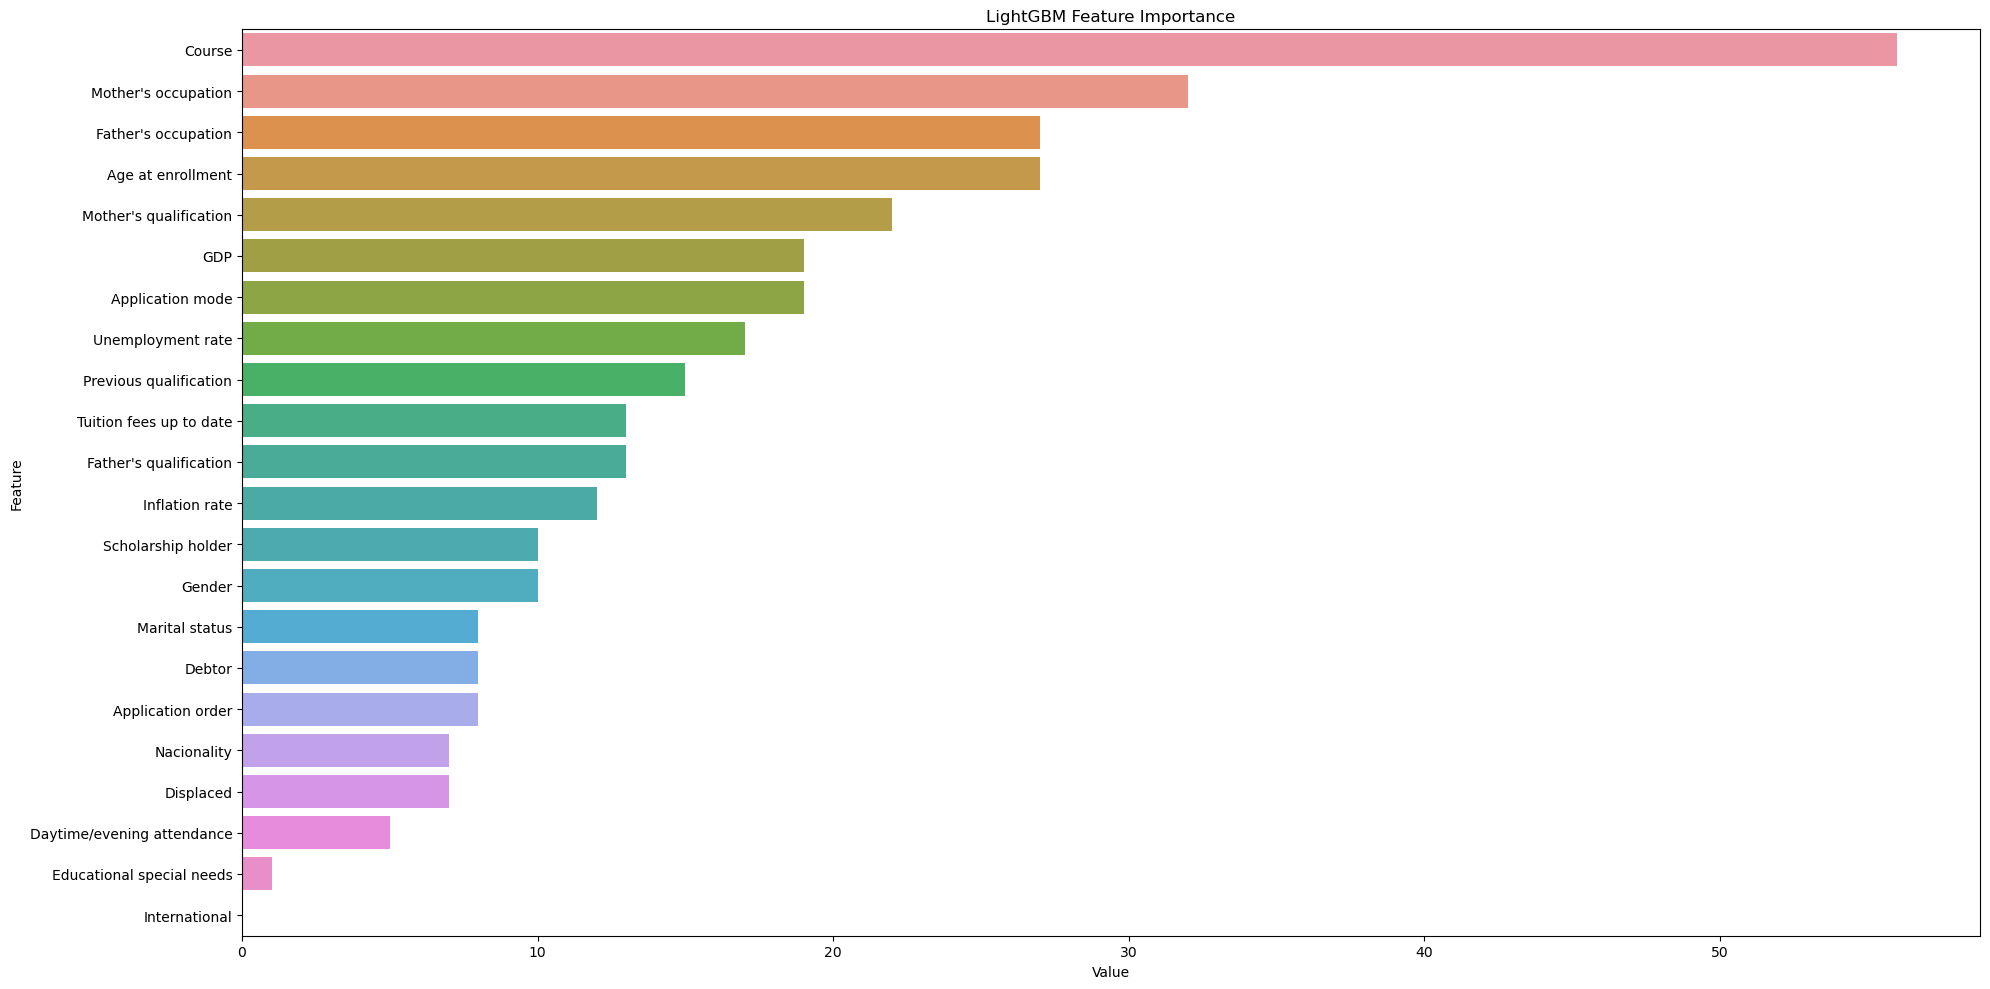

In [362]:
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,X_features.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Feature Importance')
plt.tight_layout()
plt.show()

We can observe that the factors with the highest feature importance are not those we identified as the most correlated to the target. The most important feature is the type of course the student is enrolled in. Some must have an higher rate of dropouts. Then, the parents' occupations have a strong impact on their daughter or son. Finally, we can look at the three time-dependent social-economic factors of the dataset : 'GDP', 'Unemployment rate' and 'Inflation rate'. They are within the most important features here.

# 5. Impact of using part or all of the features<a id='impact'></a>
[to the top](#top)

## 5.1 Impact of the social-economic factors<a id='demo'></a>

Another way to look at the importance of the time-dependant social-economic features is to look at the accuracy after removing them.

In [372]:
df_personal = df[['Marital status', 'Application mode', 'Application order', 'Course',
       'Daytime/evening attendance', 'Previous qualification', 'Nacionality',
       "Mother's qualification", "Father's qualification",
       "Mother's occupation", "Father's occupation", 'Displaced',
       'Educational special needs', 'Debtor', 'Tuition fees up to date',
       'Gender', 'Scholarship holder', 'Age at enrollment', 'International', 'Target']]

In [373]:
X_personal = df_personal.drop(['Target'], axis=1)
y_personal = df_personal['Target']

In [374]:
X_train, X_test, y_train, y_test = train_test_split(X_personal, y_personal, test_size = 0.15, random_state = 0)

In [375]:
clf = lgb.LGBMClassifier()

In [376]:
clf.fit(X_train, y_train)

LGBMClassifier()

In [377]:
y_pred=clf.predict(X_test)

In [378]:
accuracy=accuracy_score(y_pred, y_test)
print(f'The model accuracy is : {round(accuracy,2)}')
accuracy=accuracy_score(y_pred[y_test == 'Dropout'], y_test[y_test == 'Dropout'])
print(f'The model accuracy when the target is "Dropout" is : {round(accuracy,2)} ({len(y_pred[y_test == "Dropout"])} values tested)')
accuracy=accuracy_score(y_pred[y_test == 'Graduate'], y_test[y_test == 'Graduate'])
print(f'The model accuracy when the target is "Graduate" is : {round(accuracy,2)} ({len(y_pred[y_test == "Graduate"])} values tested)')
accuracy=accuracy_score(y_pred[y_test == 'Enrolled'], y_test[y_test == 'Enrolled'])
print(f'The model accuracy when the target is "Enrolled" is : {round(accuracy,2)} ({len(y_pred[y_test == "Enrolled"])} values tested)')

The model accuracy is : 0.65
The model accuracy when the target is "Dropout" is : 0.65 (216 values tested)
The model accuracy when the target is "Graduate" is : 0.83 (328 values tested)
The model accuracy when the target is "Enrolled" is : 0.17 (120 values tested)


The overall accuracy decreased but sligthly so the impact of the three features is small but useful.

## 5.2 Impact of adding curriculum-related features<a id='cv'></a>

So far, we did not use the features related to the the current year itself because, in a real situation, it would not be available when we want to predict the dropouts before the beginning of the year. It can still be interesting to look at the performance after adding this curriculum-related information, especially regarding the first semester.

### 5.2.1 Using only the first semester<a id='first'></a>

Indeed, it could also be useful to predict the dropouts after the results of the first semester, halfway through the year.

In [388]:
df_1stsem = df[['Marital status', 'Application mode', 'Application order', 'Course',
       'Daytime/evening attendance', 'Previous qualification', 'Nacionality',
       "Mother's qualification", "Father's qualification",
       "Mother's occupation", "Father's occupation", 'Displaced',
       'Educational special needs', 'Debtor', 'Tuition fees up to date',
       'Gender', 'Scholarship holder', 'Age at enrollment', 'International',
       'Unemployment rate','Inflation rate', 'GDP', 'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)','Target']]

In [389]:
X_1stsem = df_1stsem.drop(['Target'], axis=1)
y_1stsem = df_1stsem['Target']

In [390]:
X_train, X_test, y_train, y_test = train_test_split(X_1stsem, y_1stsem, test_size = 0.15, random_state = 0)

In [391]:
clf = lgb.LGBMClassifier()

In [392]:
clf.fit(X_train, y_train)

LGBMClassifier()

In [393]:
y_pred=clf.predict(X_test)

In [394]:
accuracy=accuracy_score(y_pred, y_test)
print(f'The model accuracy is : {round(accuracy,2)}')
accuracy=accuracy_score(y_pred[y_test == 'Dropout'], y_test[y_test == 'Dropout'])
print(f'The model accuracy when the target is "Dropout" is : {round(accuracy,2)} ({len(y_pred[y_test == "Dropout"])} values tested)')
accuracy=accuracy_score(y_pred[y_test == 'Graduate'], y_test[y_test == 'Graduate'])
print(f'The model accuracy when the target is "Graduate" is : {round(accuracy,2)} ({len(y_pred[y_test == "Graduate"])} values tested)')
accuracy=accuracy_score(y_pred[y_test == 'Enrolled'], y_test[y_test == 'Enrolled'])
print(f'The model accuracy when the target is "Enrolled" is : {round(accuracy,2)} ({len(y_pred[y_test == "Enrolled"])} values tested)')

The model accuracy is : 0.77
The model accuracy when the target is "Dropout" is : 0.81 (216 values tested)
The model accuracy when the target is "Graduate" is : 0.87 (328 values tested)
The model accuracy when the target is "Enrolled" is : 0.42 (120 values tested)


As expected, the performance is way better after adding information regarding the first semester.

### 5.2.2 Using both semesters<a id='both'></a>

In [395]:
X_all = df.drop(['Target'], axis=1)
y_all = df['Target']

In [396]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size = 0.15, random_state = 0)

In [397]:
clf = lgb.LGBMClassifier()

In [398]:
clf.fit(X_train, y_train)

LGBMClassifier()

In [399]:
y_pred=clf.predict(X_test)

In [400]:
accuracy=accuracy_score(y_pred, y_test)
print(f'The model accuracy is : {round(accuracy,2)}')
accuracy=accuracy_score(y_pred[y_test == 'Dropout'], y_test[y_test == 'Dropout'])
print(f'The model accuracy when the target is "Dropout" is : {round(accuracy,2)} ({len(y_pred[y_test == "Dropout"])} values tested)')
accuracy=accuracy_score(y_pred[y_test == 'Graduate'], y_test[y_test == 'Graduate'])
print(f'The model accuracy when the target is "Graduate" is : {round(accuracy,2)} ({len(y_pred[y_test == "Graduate"])} values tested)')
accuracy=accuracy_score(y_pred[y_test == 'Enrolled'], y_test[y_test == 'Enrolled'])
print(f'The model accuracy when the target is "Enrolled" is : {round(accuracy,2)} ({len(y_pred[y_test == "Enrolled"])} values tested)')

The model accuracy is : 0.8
The model accuracy when the target is "Dropout" is : 0.82 (216 values tested)
The model accuracy when the target is "Graduate" is : 0.89 (328 values tested)
The model accuracy when the target is "Enrolled" is : 0.53 (120 values tested)


The accuracy is just slightly better after adding the second semester as well. This is a good news that most information is contained in the first semester, when changes are still possible. However, it could also be a sign that most students drops out before the end of the first semester.

We can now observe the feature importance of the model using all features.

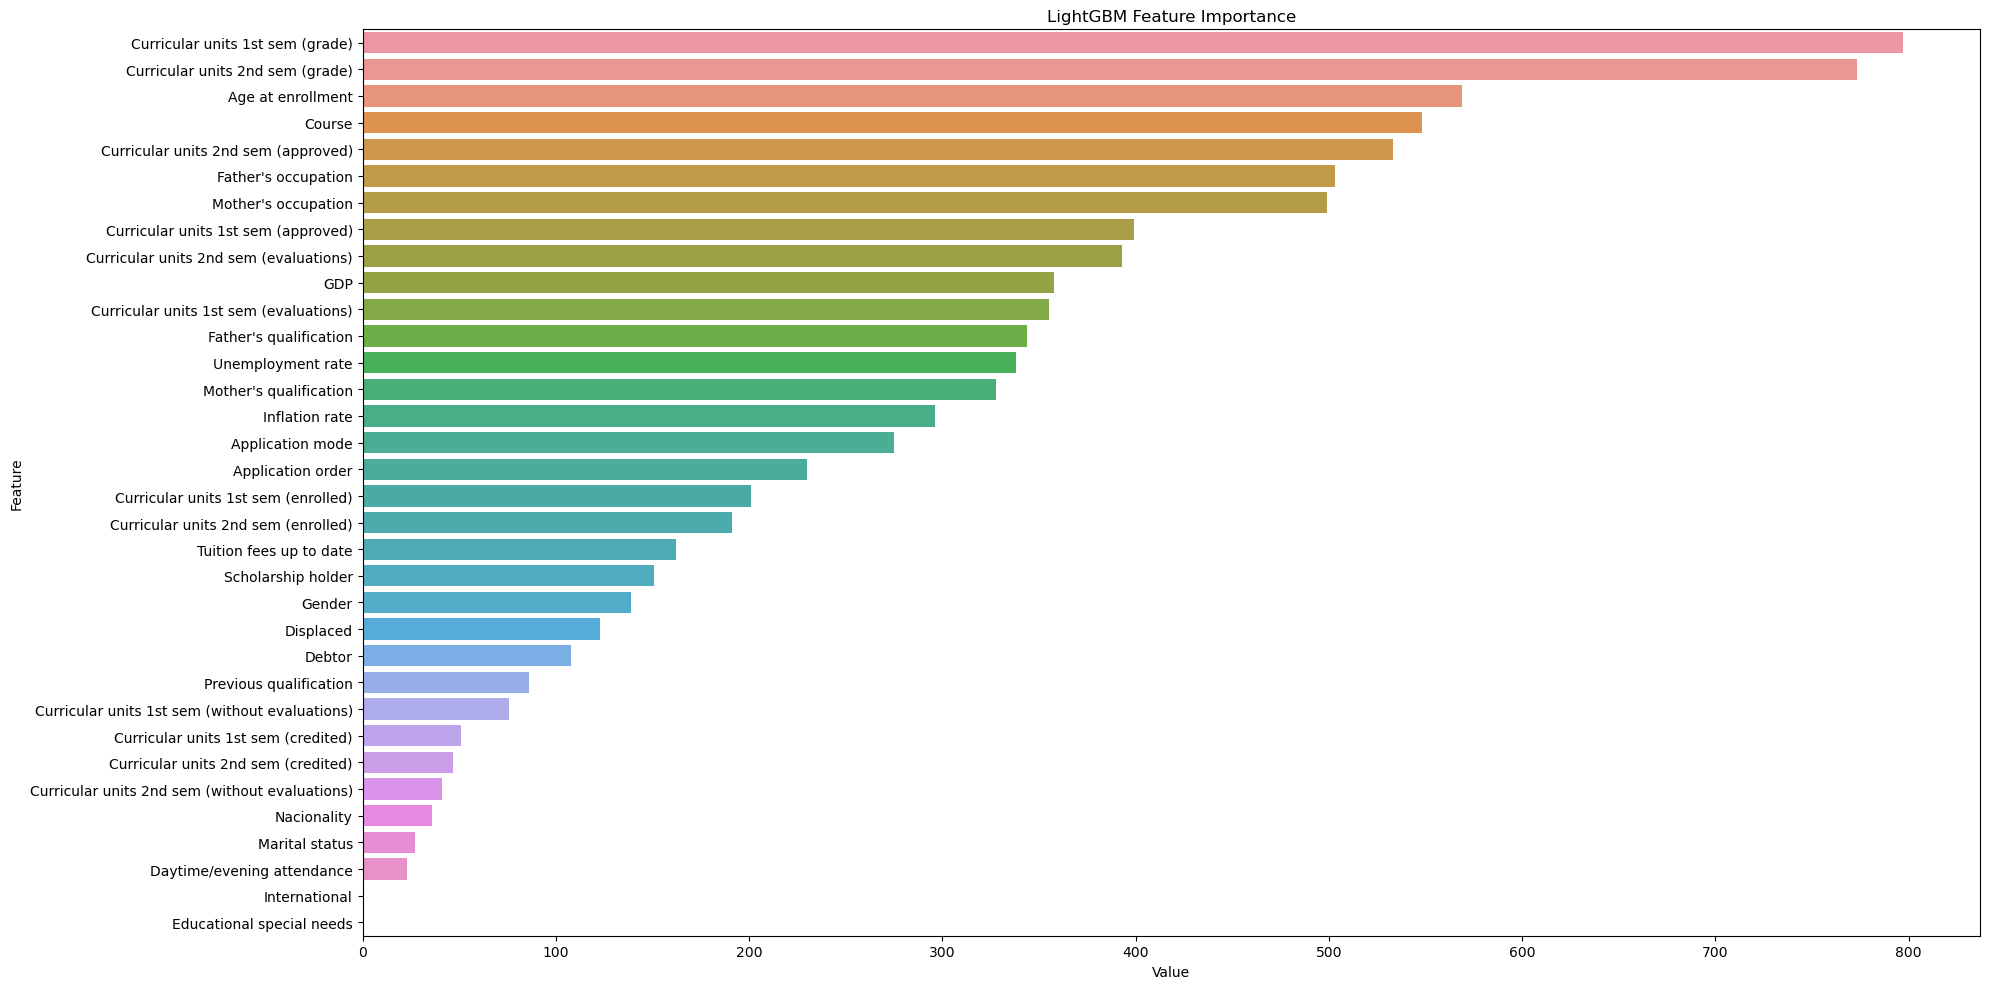

In [401]:
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,X_all.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Feature Importance')
plt.tight_layout()
plt.show()

As expected, the academic-related features are among the most important ones. Obviously, the grades are a very important signal of dropouts. Apart from that, the importance ranking is close to the previous one for the other features.

# 6. Conclusion<a id='conclusion'></a>
[to the top](#top)

Our goal was to compare different classifier for a task with a limited amount of data, to see what method would use the little info at its disposal to efficiently predict dropouts and graduations. The scond objective was to look at the impact of the different factors regarding this task. The dataset I used was already very clean so I did not have to perform preprocessing.

I compared LightGBM, Support Vector Machines, SGD Classifier, K-Nearest Neighbours, Random Forest and Feedforward Neural Networks. I reached the best overall performance with LightGBM. However, for all of these methods, the accuracy was very different across classes, all performed poorly on the minority class 'Enrolled'. This is probably due to the imbalance of the data. Then, I tried to improve the LightGBM model with a random search using cross-validation but this was not successful.

Regarding the second objective, I looked at the feature importance of this model and observed the significance of the type of course and of the parents' occupations. Then, I highlighted the impact of the three time-dependent social-economic factors contained in the data. 

Finally, I added the academic-related factors to the inputs of the model and observed that it could be interesting to use such a model to prevent dropouts after the first semester.

If I should keep working on this task, the first thing I would do would be to deal with the problem of imbalanced data. We could probably improve the performance significantly after a bit of preprocessing. The first idea is to have an equal number of each class in the training set but this would require to reduce the size of it, in a context of limited information, which could be a huge problem. There are probably other solutions to deal with it.